In [1]:
# Test
# fit a 2D KDE to the CMD
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import sys

from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm

# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.CMD_selection import *


# Standard library imports
import os
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Astropy imports

# Custom script imports, need to find a way to make this work on ALICE
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')  # Add scripts folder to path
from scripts.implied_d_vr import *  # Import specific functions or classes as needed
from scripts.selections import *
from scripts.CMD_selection import *
from scripts.catalog_preparation.prepare_gaia import *
from scripts.misc.fft_kde import WeightedFFTKDE

from healpy import ang2pix

# Multithreading libraries
import numpy as np
from multiprocessing import Pool
from classifier import *


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


The SFD'98 dust map is not in the data directory:

    /Users/mncavieres/Documents/2023-1/Investigacion2/Data/Catalogs/Dustmaps

To change the data directory, call:

    from dustmaps.config import config
    config['data_dir'] = '/path/to/data/directory'

To download the SFD'98 map to the data directory, call:

    import dustmaps.sfd
    dustmaps.sfd.fetch()



FileNotFoundError: [Errno 2] No such file or directory: '/Users/mncavieres/Documents/2023-1/Investigacion2/Data/Catalogs/Dustmaps/sfd/SFD_dust_4096_ngp.fits'

In [ ]:

class BayesianKDEClassifier:

    def __init__(self, speedy_catalog, gaia_catalog, threshold=0.9, bandwidth=0.1, imf = None):

        healpix_level = 4
        self.nside = 2**healpix_level

        self.imf = imf

        self.threshold = threshold
        self.base_bandwidth = bandwidth

        self.speedy_catalog = speedy_catalog
        self.gaia_catalog = gaia_catalog

        # Make sure that we are only dealing with sources observable by Gaia
        # select visible by Gaia DR4
        self.speedy_catalog = self.speedy_catalog .loc[self.speedy_catalog ['phot_g_mean_mag']< 21]
        # select only point sbetween bp-rp = -1 and 3 and G_I = 10 and -7
        self.speedy_catalog  = self.speedy_catalog.loc[(self.speedy_catalog['bp_rp_corr'] > -1.2) &
                                                        (self.speedy_catalog['bp_rp_corr'] < 2) & 
                                                        (self.speedy_catalog['implied_M_g_corr'] > -8) &
                                                        (self.speedy_catalog['implied_M_g_corr'] < 9)].copy()

        
        self.total_n_hvs = len(self.speedy_catalog)
        

        # Split data by class
        X_class = self.speedy_catalog['bp_rp_corr'].values
        Y_class = self.speedy_catalog['implied_M_g_corr'].values
        X_not_class = self.gaia_catalog['bp_rp_corr'].values
        Y_not_class = self.gaia_catalog['implied_M_g_corr'].values

        # Select sources in the speedystar catalog that are in the same healpix as the gaia catalog, note that this makes the catalog smaller and it is somewhat destructive
        self.select_speedystar_pixel()

        # Calculate prior probabilities
        n_hvs_pixel = (len(self.speedy_catalog)/self.total_n_hvs)*56.9
        self.p_class = n_hvs_pixel/(n_hvs_pixel + len(self.gaia_catalog))
        self.p_not_class = 1 - self.p_class

        # Fit 2D KDEs for each class with base bandwidth
        XY_class = np.vstack([X_class, Y_class]).T
        XY_not_class = np.vstack([X_not_class, Y_not_class]).T

        self.kde_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(XY_class)
        self.kde_not_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(XY_not_class)

        # for grid interpolation
        self.X_class = X_class
        self.Y_class = Y_class
        self.X_not_class = X_not_class
        self.Y_not_class = Y_not_class

        # Number of samples in each class
        self.n_class = len(self.X_class)
        self.n_not_class = len(self.X_not_class)

    def select_speedystar_pixel(self): 

        """
        Extract simulated stars for the same healpix pixel as the Gaia data.

        This only makes sence with the prior knowledge that the Gaia data is
        saved and structured in ALICE by HEALPix pixel, and that I will run
        the script in a HEALPix basis.
        """
        # select a star in the gaia data
        l, b = self.gaia_catalog['l'].values[10], self.gaia_catalog['b'].values[10]

        # obtain the HEALPix pixel of the Gaia catalog
        healpix_pixel = ang2pix(self.nside, l, b, lonlat= True)
        self.healpix_pixel = healpix_pixel

        # if the speedystar catalog does not have the "HEALPix" column compute it
        if 'HEALPix' in self.speedy_catalog.columns:
            pass
        else:
            self.speedy_catalog['HEALPix'] = ang2pix(self.nside, self.speedy_catalog.l, self.speedy_catalog.b, lonlat= True)
             

        # select only sources in the speedy catalog that match with the healpix of the gaia catalog
        self.speedy_catalog = self.speedy_catalog.loc[self.speedy_catalog['HEALPix'].values == healpix_pixel]

   
    def compute_kde_grid(self, x_range=(-1, 2.5), y_range=(-7, 15), resolution=100):
        """
        Compute a grid of KDE evaluations for each class.
        """
        X_range = np.linspace(x_range[0], x_range[1], resolution)
        Y_range = np.linspace(y_range[0], y_range[1], resolution)
        X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
        XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

        log_p_class_grid = self.kde_class.score_samples(XY_mesh).reshape(resolution, resolution)
        log_p_not_class_grid = self.kde_not_class.score_samples(XY_mesh).reshape(resolution, resolution)

        self.p_class_grid = np.exp(log_p_class_grid)
        self.p_not_class_grid = np.exp(log_p_not_class_grid)
        self.X_range, self.Y_range = X_range, Y_range

    def compute_kde_grid_weighted(self, x_range=(-1, 2.5), y_range=(-7, 15), resolution=100, alpha_ini = 2.3):
        # We will weight the training catalog to mimick a different IMF
        # compute weights
        weights = change_imf_weights(self.speedy_catalog.m.values,
                                      alpha_ini=alpha_ini,
                                      alpha_new=self.imf)
        
        XY_class = np.vstack([self.X_class, self.Y_class]).T
        XY_not_class = np.vstack([self.X_not_class, self.Y_not_class]).T
        
        
        # fit KDE with weights
        kde_class = WeightedFFTKDE(bw=0.1, grid_size=2560, margin=0.5).fit(
            XY_class,
            weights=weights
        )


        # Compute a grid of KDE evaluations for each class.

        X_range = np.linspace(x_range[0], x_range[1], resolution)
        Y_range = np.linspace(y_range[0], y_range[1], resolution)
        X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
        XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

        #log_p_class_grid = self.kde_class.score_samples(XY_mesh).reshape(resolution, resolution)
        log_p_class_grid = kde_class.evaluate(XY_mesh).reshape(resolution, resolution)
        log_p_not_class_grid = self.kde_not_class.score_samples(XY_mesh).reshape(resolution, resolution)

        self.p_class_grid = np.exp(log_p_class_grid)
        self.p_not_class_grid = np.exp(log_p_not_class_grid)
        self.X_range, self.Y_range = X_range, Y_range


    def classify_with_error_convolution(self, x, y, x_err, y_err):
        """
        Classify points using convolution with Gaussian error and grid interpolation.
        """
        # # Create interpolators for the KDE grids
        # interpolator_class = RegularGridInterpolator((self.X_range, self.Y_range), self.p_class_grid)
        # interpolator_not_class = RegularGridInterpolator((self.X_range, self.Y_range), self.p_not_class_grid)

        # Convolve KDE grids with Gaussian filters based on errors
        convolved_class_grid = gaussian_filter(self.p_class_grid, sigma=[x_err, y_err])
        convolved_not_class_grid = gaussian_filter(self.p_not_class_grid, sigma=[x_err, y_err])

        # Interpolators for convolved KDE grids
        convolved_interpolator_class = RegularGridInterpolator((self.X_range, self.Y_range), convolved_class_grid)
        convolved_interpolator_not_class = RegularGridInterpolator((self.X_range, self.Y_range), convolved_not_class_grid)

        # Interpolate convolved KDEs at the (x, y) point
        data_points = np.vstack([x, y]).T
        p_data_given_class = convolved_interpolator_class(data_points)
        p_data_given_not_class = convolved_interpolator_not_class(data_points)

        # Calculate total probability and posterior probabilities
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data

        # Classification based on threshold
        classification = p_class_given_data >= self.threshold

        return classification, p_class_given_data, p_not_class_given_data, p_data
    
    def classify(self, x, y, x_err=0, y_err=0):
        """
        Classify points based on the KDE-based Bayesian model with analytical error integration.

        Parameters:
        - x (array-like): Input data for feature X.
        - y (array-like): Input data for feature Y.
        - x_err (float or array-like): Standard deviation of errors in X.
        - y_err (float or array-like): Standard deviation of errors in Y.

        Returns:
        - classification (bool array): True if classified as part of the class, False otherwise.
        - p_class_given_data (array): Probability of being in the class.
        - p_not_class_given_data (array): Probability of not being in the class.
        - p_data (array): Total probability of the data.
        """

        # Create temporary KDEs with adjusted bandwidths for each case
        #kde_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth)
        #kde_class.fit(np.vstack([self.X[self.C], self.Y[self.C]]).T)
        
        #kde_not_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth)
        #kde_not_class.fit(np.vstack([self.X[~self.C], self.Y[~self.C]]).T)
        
        # Prepare input data
        data = np.vstack([x, y]).T
        
        # Calculate log-likelihoods with adjusted KDEs
        log_p_data_given_class = self.kde_class.score_samples(data)
        log_p_data_given_not_class = self.kde_not_class.score_samples(data)
        
        # Convert log-likelihoods to likelihoods
        p_data_given_class = np.exp(log_p_data_given_class)
        p_data_given_not_class = np.exp(log_p_data_given_not_class)
        
        # Total probability of data
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class
        
        # Posterior probabilities P(class|data) and P(not class|data)
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data
        
        # Classification based on threshold
        classification = p_class_given_data >= self.threshold
        
        return classification, p_class_given_data, p_not_class_given_data, p_data
    
    def classify_local_approx(self, x, y, x_err, y_err, nsigmas=3):
        """
        Classify a single object by locally approximating the convolution of the KDE grid
        with the measurement error Gaussian.

        Parameters
        ----------
        x, y : float
            Coordinates in CMD space (e.g., bp_rp_corr, implied_M_g_corr).
        x_err, y_err : float
            Measurement uncertainties along x and y axes.
        nsigmas : int, optional
            Defines the local region size as ±nsigmas*x_err and ±nsigmas*y_err around (x, y).

        Returns
        -------
        classification : bool
            True if p(class|data) >= threshold, else False.
        p_class_given_data : float
            Posterior probability of class given the data.
        p_not_class_given_data : float
            Posterior probability of not-class given the data.
        p_data : float
            Probability of data under both hypotheses combined.
        """

        dx = self.X_range[1] - self.X_range[0]
        dy = self.Y_range[1] - self.Y_range[0]

        # Determine the local region in the grid around (x,y)
        x_min = x - nsigmas * x_err
        x_max = x + nsigmas * x_err
        y_min = y - nsigmas * y_err
        y_max = y + nsigmas * y_err

        # Find the indices in the grid that correspond to this local region
        ix_min = np.searchsorted(self.X_range, x_min)
        ix_max = np.searchsorted(self.X_range, x_max)
        iy_min = np.searchsorted(self.Y_range, y_min)
        iy_max = np.searchsorted(self.Y_range, y_max)

        # Ensure indices are within the grid bounds
        ix_min = max(ix_min, 0)
        ix_max = min(ix_max, len(self.X_range)-1)
        iy_min = max(iy_min, 0)
        iy_max = min(iy_max, len(self.Y_range)-1)

        # Extract the local patches
        local_X = self.X_range[ix_min:ix_max+1]
        local_Y = self.Y_range[iy_min:iy_max+1]

        local_p_class = self.p_class_grid[iy_min:iy_max+1, ix_min:ix_max+1]
        local_p_not_class = self.p_not_class_grid[iy_min:iy_max+1, ix_min:ix_max+1]

        # Create a 2D Gaussian kernel for the errors
        # Meshgrid of local coords
        X_mesh, Y_mesh = np.meshgrid(local_X, local_Y)
        # Gaussian weight ~ exp(-((x'-x)^2/(2*x_err^2) + (y'-y)^2/(2*y_err^2)))
        gauss_exp = -(((X_mesh - x)**2/(2*x_err**2)) + ((Y_mesh - y)**2/(2*y_err**2)))
        gauss_raw = np.exp(gauss_exp)

        # Normalize the Gaussian so that ∑ gauss[i,j]*dx*dy = 1
        gauss_sum = np.sum(gauss_raw)*dx*dy
        gauss = gauss_raw / gauss_sum

        # Compute p(data|class) and p(data|not_class) as the integral of p(...) * gauss
        # p_data_given_class = ∑ local_p_class[i,j] * gauss[i,j] * dx * dy over the patch
        # But we already normalized gauss to integrate to 1 over the patch,
        # so no need to multiply by dx*dy again here. gauss is a PDF over this patch.
        # Actually, we DO need to think carefully:
        # gauss is normalized with dx*dy. If gauss is a PDF, then ∑ gauss[i,j]*dx*dy = 1.
        # local_p_class and local_p_not_class are densities, so the integral:
        # p_data_given_class = ∑ local_p_class[i,j] * gauss[i,j]*dx*dy
        # Since gauss[i,j]*dx*dy sums to 1, we must re-multiply by dx*dy:
        
        p_data_given_class = np.sum(local_p_class * gauss)*dx*dy
        p_data_given_not_class = np.sum(local_p_not_class * gauss)*dx*dy

        # Now combine with priors
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data

        # Classification decision
        classification = p_class_given_data >= self.threshold

        return classification, p_class_given_data, p_not_class_given_data, p_data

    def classify_all_local_approx(self, mode='multiprocessing', n_workers=4, nsigmas=3):
        """
        Classify all objects in self.gaia_catalog using classify_local_approx.
        
        Parameters
        ----------
        mode : str, optional
            'multiprocessing' or 'MPI'. Defaults to 'multiprocessing'.
        n_workers : int, optional
            Number of processes for multiprocessing. Ignored if mode='MPI'.
        nsigmas : int, optional
            The nsigmas parameter passed to classify_local_approx.

        Returns
        -------
        results_df : pandas.DataFrame
            A DataFrame with columns:
            'classification', 'p_class_given_data', 'p_not_class_given_data', 'p_data'
            aligned with rows of self.gaia_catalog.
        """

        # Extract necessary columns from gaia_catalog
        x = self.gaia_catalog['bp_rp_corr'].values
        y = self.gaia_catalog['implied_M_g_corr'].values
        # Assume error columns exist; adjust names if needed
        x_err = self.gaia_catalog['bp_rp_corr_error'].values
        y_err = self.gaia_catalog['implied_M_g_corr_error'].values

        if mode == 'multiprocessing':
            # ---- Multiprocessing implementation ----
            # Prepare input data as tuples
            input_data = [(x[i], y[i], x_err[i], y_err[i], nsigmas) for i in range(len(x))]

            with Pool(processes=n_workers) as pool:
                # Map the classify_local_approx call over all objects
                # We'll create a small wrapper function below to handle partial arguments
                results = pool.starmap(self._classify_local_approx_wrapper, input_data)

        elif mode == 'MPI':
            # ---- MPI implementation ----
            from mpi4py import MPI
            comm = MPI.COMM_WORLD
            rank = comm.Get_rank()
            size = comm.Get_size()

            # Scatter the data
            # We need to split x, y, x_err, y_err into chunks
            n_total = len(x)
            counts = [n_total // size + (1 if i < n_total % size else 0) for i in range(size)]
            displs = [sum(counts[:i]) for i in range(size)]

            # Local arrays
            local_n = counts[rank]
            local_x = np.zeros(local_n, dtype=float)
            local_y = np.zeros(local_n, dtype=float)
            local_x_err = np.zeros(local_n, dtype=float)
            local_y_err = np.zeros(local_n, dtype=float)

            # Scatter the data to each process
            comm.Scatterv([x, counts, displs, MPI.DOUBLE], local_x, root=0)
            comm.Scatterv([y, counts, displs, MPI.DOUBLE], local_y, root=0)
            comm.Scatterv([x_err, counts, displs, MPI.DOUBLE], local_x_err, root=0)
            comm.Scatterv([y_err, counts, displs, MPI.DOUBLE], local_y_err, root=0)

            # Each process classifies its portion
            local_results = []
            for i in range(local_n):
                classification, p_class_given_data, p_not_class_given_data, p_data = \
                    self.classify_local_approx(local_x[i], local_y[i], local_x_err[i], local_y_err[i], nsigmas=nsigmas)
                local_results.append((classification, p_class_given_data, p_not_class_given_data, p_data))

            # Now we need to gather results back to rank 0
            # Convert local_results to a numpy array for easier gathering
            local_results_arr = np.array(local_results, dtype=[('classification', '?'),
                                                               ('p_class_given_data', 'f8'),
                                                               ('p_not_class_given_data', 'f8'),
                                                               ('p_data', 'f8')])
            # Prepare global array on root
            if rank == 0:
                global_results_arr = np.empty(n_total, dtype=local_results_arr.dtype)
            else:
                global_results_arr = None

            # Gather results
            comm.Gatherv(local_results_arr, [global_results_arr, counts, displs, MPI._typedict['?f8f8f8']], root=0)

            # Only rank 0 will have the full results
            if rank != 0:
                return None  # Non-root ranks don't return
            else:
                results = list(global_results_arr)

        else:
            raise ValueError("mode must be either 'multiprocessing' or 'MPI'")

        # If we reach here, we have 'results' as a list of tuples:
        # (classification, p_class_given_data, p_not_class_given_data, p_data)
        # We can put them into a DataFrame aligned with self.gaia_catalog rows.
        import pandas as pd
        results_df = pd.DataFrame(results, columns=['classification', 'p_class_given_data', 'p_not_class_given_data', 'p_data'])

        return results_df

    def _classify_local_approx_wrapper(self, x, y, x_err, y_err, nsigmas):
        """
        Wrapper function to call classify_local_approx with given parameters.
        This is needed since starmap only allows passing a tuple of arguments.
        """
        classification, p_class_given_data, p_not_class_given_data, p_data = self.classify_local_approx(x, y, x_err, y_err, nsigmas=nsigmas)
        return classification, p_class_given_data, p_not_class_given_data, p_data


    def debug_kde_fit(self, x_range=(-1, 2.5), y_range=(15, -7), resolution=100):
        """
        Debug KDE by plotting it alongside the original data to compare fit.

        Parameters:
        - x_range (tuple): Range of x values for the plot (default is (-1, 2.5)).
        - y_range (tuple): Range of y values for the plot (default is (15, -7)).
        - resolution (int): Number of points along each axis (default is 100).
        """

        # calculate log-likelihoods with the KDEs for a range of data points to plot contours
        X_range = np.linspace(x_range[0], x_range[1], resolution)
        Y_range = np.linspace(y_range[0], y_range[1], resolution)
        X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
        XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

        log_p_data_given_hvs = self.kde_class.score_samples(XY_mesh)
        log_p_data_given_not_hvs = self.kde_not_class.score_samples(XY_mesh)

        # plot the KDE and the original data for each class
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot the "class" data
        ax[0].scatter(self.X_class, self.Y_class, s=1, c='blue', alpha=0.5)
        cbar_1 = ax[0].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_hvs).reshape(resolution, resolution),
                                 cmap='Blues', levels = 20, alpha = 0.6)
        ax[0].set_title('HVS KDE')
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range)
        ax[0].set_xlabel("$G_{bp} - G_{rp}$")
        ax[0].set_ylabel("$G_{I}$")

        # Plot the "not class" data
        ax[1].scatter(self.X_not_class, self.Y_not_class, s=1, c='red', alpha=0.5)
        cbar_2 = ax[1].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_not_hvs).reshape(resolution, resolution),
                                 cmap='Reds', levels = 30, alpha = 0.6)
        ax[1].set_title('Non-HVS KDE')
        ax[1].set_xlim(x_range)
        ax[1].set_ylim(y_range)
        ax[1].set_xlabel("$G_{bp} - G_{rp}$")
        ax[1].set_ylabel("$G_{I}$")

        # add colorbars
        fig.colorbar(cbar_1, ax=ax[0], label = '$P(data|hvs)$')
        fig.colorbar(cbar_2, ax=ax[1], label = '$P(data|non-hvs)$')

        plt.tight_layout()
        plt.show()

    def debug_kde_fit_2(self, x_range=(-1, 2.5), y_range=(15, -7), resolution=100):
        """
        Debug KDE by plotting it alongside the original data to compare fit.

        Parameters:
        - x_range (tuple): Range of x values for the plot (default is (-1, 2.5)).
        - y_range (tuple): Range of y values for the plot (default is (15, -7)).
        - resolution (int): Number of points along each axis (default is 100).
        """

        # calculate log-likelihoods with the KDEs for a range of data points to plot contours
        X_range = np.linspace(x_range[0], x_range[1], resolution)
        Y_range = np.linspace(y_range[0], y_range[1], resolution)
        X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
        XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

        log_p_data_given_hvs = self.kde_class.score_samples(XY_mesh)
        log_p_data_given_not_hvs = self.kde_not_class.score_samples(XY_mesh)

        # plot the KDE and the original data for each class
        fig, ax = plt.subplots(1, 3, figsize=(20, 6))

        # Plot the "class" data
        ax[0].scatter(self.X_class, self.Y_class, s=1, c='blue', alpha=0.5)
        cbar_1 = ax[0].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_hvs).reshape(resolution, resolution),
                                cmap='Blues', levels=20, alpha=0.6)
        ax[0].set_title('HVS KDE')
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range)
        ax[0].set_xlabel("$G_{bp} - G_{rp}$")
        ax[0].set_ylabel("$G_{I}$")

        # Plot the "not class" data
        ax[1].scatter(self.X_not_class, self.Y_not_class, s=1, c='red', alpha=0.5)
        cbar_2 = ax[1].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_not_hvs).reshape(resolution, resolution),
                                cmap='Reds', levels=30, alpha=0.6)
        ax[1].set_title('Non-HVS KDE')
        ax[1].set_xlim(x_range)
        ax[1].set_ylim(y_range)
        ax[1].set_xlabel("$G_{bp} - G_{rp}$")
        ax[1].set_ylabel("$G_{I}$")

        # Plot the division of the two KDEs
        division = (np.exp(log_p_data_given_hvs) / np.exp(log_p_data_given_not_hvs)).reshape(resolution, resolution)
        cbar_3 = ax[2].contourf(X_mesh, Y_mesh, division, cmap='coolwarm', levels=30, alpha=0.6)
        ax[2].set_title('HVS/Non-HVS KDE Ratio')
        ax[2].set_xlim(x_range)
        ax[2].set_ylim(y_range)
        ax[2].set_xlabel("$G_{bp} - G_{rp}$")
        ax[2].set_ylabel("$G_{I}$")

        # add colorbars
        fig.colorbar(cbar_1, ax=ax[0], label='$P(data|hvs)$')
        fig.colorbar(cbar_2, ax=ax[1], label='$P(data|non-hvs)$')
        fig.colorbar(cbar_3, ax=ax[2], label='HVS/Non-HVS Ratio')

        plt.tight_layout()
        plt.show()

    def plot_posterior(self, x_range=(-1, 2.5), y_range=(15, -7), grid_size=100, x_err=0.1, y_err=0.1):
        """
        Plots the posterior probability P(class | data) on a grid of points within the given x and y range,
        using the `classify_with_error_convolution` method to account for Gaussian error convolution.

        Args:
            x_range (tuple): Range of x values (min, max).
            y_range (tuple): Range of y values (min, max).
            grid_size (int): Number of points in the grid along each axis.
            x_err (float): Error in the x dimension for Gaussian convolution.
            y_err (float): Error in the y dimension for Gaussian convolution.
        """
        # Create a grid of points
        x = np.linspace(x_range[0], x_range[1], grid_size)
        y = np.linspace(y_range[0], y_range[1], grid_size)
        X, Y = np.meshgrid(x, y)
        grid_points = np.vstack([X.ravel(), Y.ravel()]).T

        # Prepare arrays for error values
        x_errors = np.full(grid_points.shape[0], x_err)
        y_errors = np.full(grid_points.shape[0], y_err)
        posterior = np.zeros_like(X, dtype=float)
        # Compute posterior probabilities using the classify_with_error_convolution method
        # Iteratively compute posterior probabilities for each grid point
        for i in tqdm(range(X.shape[0])):
            for j in range(X.shape[1]):
                try:
                    _, p_class_given_data, _, _ = self.classify_with_error_convolution(
                        X[i, j], Y[i, j], 0, 0
                    )
                    posterior[i, j] = p_class_given_data
                except ValueError:
                    # This can happen if it is out of bounds from the pre computed grid
                    posterior[i, j] = 0 # we fill with 0 because whatever

        # Reshape posterior to grid size
        #posterior = p_class_given_data.reshape(grid_size, grid_size)

        # Plot the posterior probability
        plt.figure(figsize=(7, 10))
        plt.contourf(X, Y, posterior, levels=100, cmap='viridis')
        plt.colorbar(label="Posterior P(class | data)")
        plt.xlabel("$G_{bp} - G_{RP}$")
        plt.ylabel("$G_I$")
        plt.ylim(y_range[0], y_range[1])
        plt.title("P(HVS|Data)")

        plt.show()

        # Save the posterior grid and coordinates for further use
        self.posterior_grid = posterior
        self.grid_x = x
        self.grid_y = y


    # def save(self, filename):
    #     """
    #     Save the KDE object to a file.

    #     Parameters:
    #     - filename (str): Name of the file to save the classifier.
    #     """
    #     with open(filename, 'wb') as f:
    #         pickle.dump(self, f)
        
    # def load(self, filename):
    #     """
    #     Load the KDE object from a pickle dump.

    #     Parameters:
    #     - filename (str): Name of the file to load the classifier.
    #     """
    #     with open(filename, 'rb') as f:
    #         self = pickle.load(f)
    #     return self


def flux_to_mag(flux):
    return -2.5*np.log10(flux)


In [3]:
# fit the KDE with a training catalog and plot it

simulation_path = "/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_long.fits" # This should be the simulation that we will use to train the classifier

# Define the healpix pixel level, which defines the NSIDE parameter and the number of pixels, this has to stay the same because this is how the data was donwloaded
healpix_level = 4
nside = 2**healpix_level
npix = hp.nside2npix(nside) 

# load the simulation
speedycatalog = Table.read(simulation_path)
print('Simulation loaded')
#speedycatalog = speedycatalog.to_pandas()
# check that bp_rp_corr and implied_M_g_corr columns are in the simulation
if 'bp_rp_corr' not in speedycatalog.colnames: # this deals with the case in which the input catalog is not ready
    print('Simulation not prepared, running preparation')
    speedycatalog = prepare_speedystar(speedycatalog) # this will turn it into a pandas dataframe

else: # if it has already been processed we only need to turn it into a dataframe
    speedycatalog = speedycatalog.to_pandas()

gaia_catalog = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/gaia_by_healpix/healpix_2161.fits')

# make sure that this column exists
gaia_catalog['bp_rp'] = gaia_catalog['phot_bp_mean_mag'] - gaia_catalog['phot_rp_mean_mag']

# prepare the gaia catalog by computing implied quantities, correcting extinction, etc.
gaia_catalog = prepare_gaia(gaia_catalog) # now gaia_catalog should have all the implied magnitudes and extinction corrections necessary for classificaiton

# first cut, remove stars with inconsistent parallax
gaia_catalog = gaia_catalog.loc[parallax_consistency(gaia_catalog.parallax, 
                                                              gaia_catalog.parallax_error, 
                                                              gaia_catalog.implied_parallax,
                                                              gaia_catalog.implied_parallax_error)]

# second cut, remove stars that are too slow to be a hypervelocity star
gaia_catalog = gaia_catalog.loc[is_fast(gaia_catalog.VGCR, lower_limit=300)]

# third cut, limit extinction to a sensible range, but still big
gaia_catalog = gaia_catalog.loc[gaia_catalog['A_G'] < 3]

# fourth cut, limit the color and magntiude range to a sensible space that also allows the KDE to fit correcty
# particularly the extinction correctio is only valid within the bp-rp range -0.5 to 2.5, we will extend a bit because of the assumption that stars are beyond the extinction layer
gaia_catalog = gaia_catalog.loc[(gaia_catalog['bp_rp_corr'] > -1.2) &
                                  (gaia_catalog['bp_rp_corr'] < 2.5) &
                                    (gaia_catalog['implied_M_g_corr'] > -8) &
                                      (gaia_catalog['implied_M_g_corr'] < 9)].copy()

#print(len(speedycatalog))
# initialize classifier
classifier = BayesianKDEClassifier(
speedy_catalog=speedycatalog,
gaia_catalog=gaia_catalog,
threshold=0.9,        # 90% confidence threshold
bandwidth=0.1,         # bandwidth for KDE smoothing
imf=None,              # new IMF slope we want to use, it is smarter to just use the catalog as is, specially becasue the KDE is more precise if we do not weight it 
)

print('Computing KDE grid for interpolations')
# pre-compute the KDE grid so that evaluations are actually interpolations
classifier.compute_kde_grid(x_range=(-1, 2), y_range=(-7, 9), resolution=100)

print('Plotting')
# plot the posterior for a grid of points
#classifier.debug_kde_fit_2()

# classifier.plot_posterior(x_range=(-1, 2), y_range=(-7, 9))

Simulation loaded
Simulation not prepared, running preparation


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Computing KDE grid for interpolations
Plotting


# Plot posterior

In [4]:
# Generate the grid
x_i = np.linspace(-1, 2.5, 300)
y_i = np.linspace(15, -7, 300)
X, Y = np.meshgrid(x_i, y_i)

# Flatten X and Y to a 1D array of points
X_flat = X.ravel()
Y_flat = Y.ravel()

# Calculate probabilities for all points at once
classification, hvs_prob_flat, background_prob_flat, total_prob_flat = classifier.classify(X_flat, Y_flat)

# Reshape the results back to the grid shape
hvs_prob = hvs_prob_flat.reshape(X.shape)
background_prob = background_prob_flat.reshape(X.shape)
total_probability = total_prob_flat.reshape(X.shape)


/Users/mncavieres/Documents/2024-2/HVS/Classify/classifier.py:295: RuntimeWarning: invalid value encountered in divide
  p_class_given_data = (p_data_given_class * self.p_class) / p_data
/Users/mncavieres/Documents/2024-2/HVS/Classify/classifier.py:296: RuntimeWarning: invalid value encountered in divide
  p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data


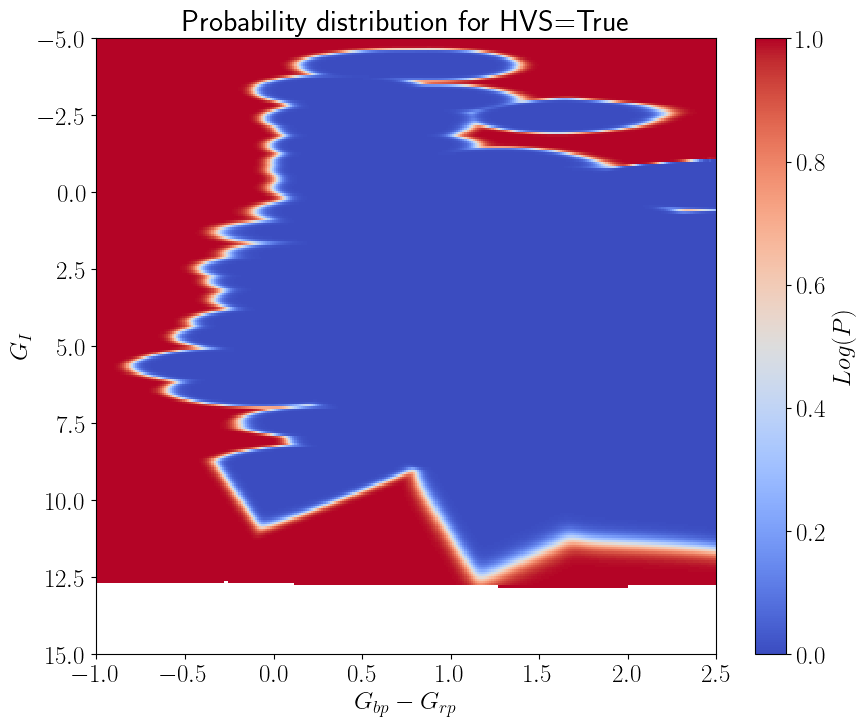

In [5]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, hvs_prob, cmap='coolwarm', shading= 'auto')# norm=colors.LogNorm(vmin=hvs_prob.min()+1e-11, vmax=hvs_prob.max()) ) #
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.set_xlim(-1, 2.5)
ax.set_ylim(15, -5)
#ax.invert_yaxis()
ax.set_title('Probability distribution for HVS=True')
fig.colorbar(c, label='$Log(P)$')
plt.show()

In [5]:
classifier.p_class = 0.5

In [6]:
classifier.p_not_class = 0.5

In [10]:
classifier.compute_kde_grid(x_range=(-2, 3), y_range=(-9, 15), resolution=120)


In [11]:
x_range=(-1, 2.5)
y_range=(15, -7)
grid_size = 120
x = np.linspace(x_range[0], x_range[1], grid_size)
y = np.linspace(y_range[0], y_range[1], grid_size)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Prepare arrays for error values

posterior = np.zeros_like(X, dtype=float)
p_background = np.zeros_like(X, dtype=float)
# Compute posterior probabilities using the classify_with_error_convolution method
# Iteratively compute posterior probabilities for each grid point
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        try:
            #classification, p_class_given_data, p_not_class_given_data, p_data
            _, p_class_given_data, p_not_class_given_data, _ = classifier.classify_with_error_convolution(
                X[i, j], Y[i, j], 0, 0
            )
            posterior[i, j] = p_class_given_data
            p_background[i, j] = p_not_class_given_data
        except ValueError:
            # This can happen if it is out of bounds from the pre computed grid
            posterior[i, j] = 0 # we fill with 0 because whatever

# Reshape posterior to grid size
#posterior = p_class_given_data.reshape(grid_size, grid_size)



  0%|          | 0/120 [00:00<?, ?it/s]/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_12892/3747977513.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior[i, j] = p_class_given_data
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_12892/3747977513.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_background[i, j] = p_not_class_given_data
100%|██████████| 120/120 [00:03<00:00, 32.03it/s]


/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_12892/1082701615.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.hist(posterior.ravel()/p_background.ravel(), range=(0, 1e10), bins = 100)


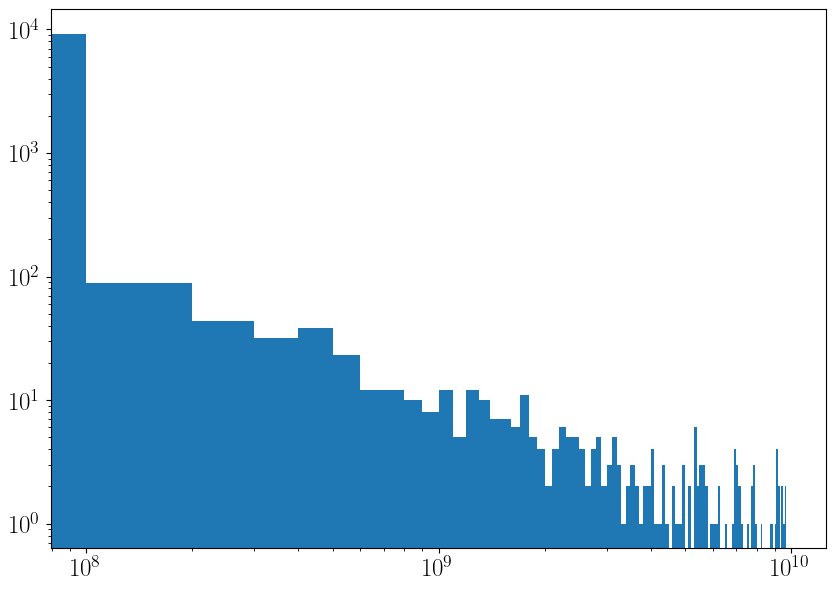

In [24]:
plt.hist(posterior.ravel()/p_background.ravel(), range=(0, 1e10), bins = 100)
plt.yscale('log')
plt.xscale('log')
plt.show()

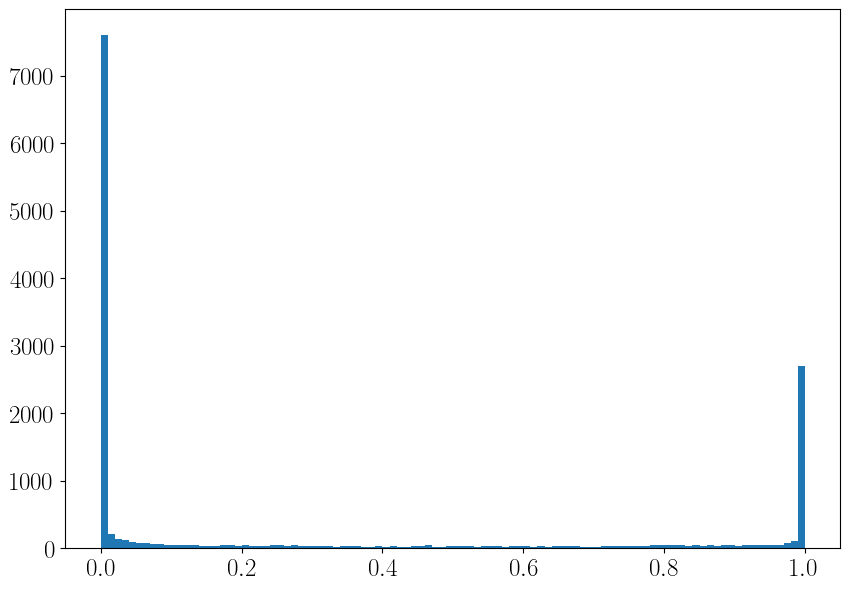

In [30]:
plt.hist(p_background.ravel(), range=(0, 1), bins = 100)
#plt.yscale('log')
#plt.xscale('log')
plt.show()

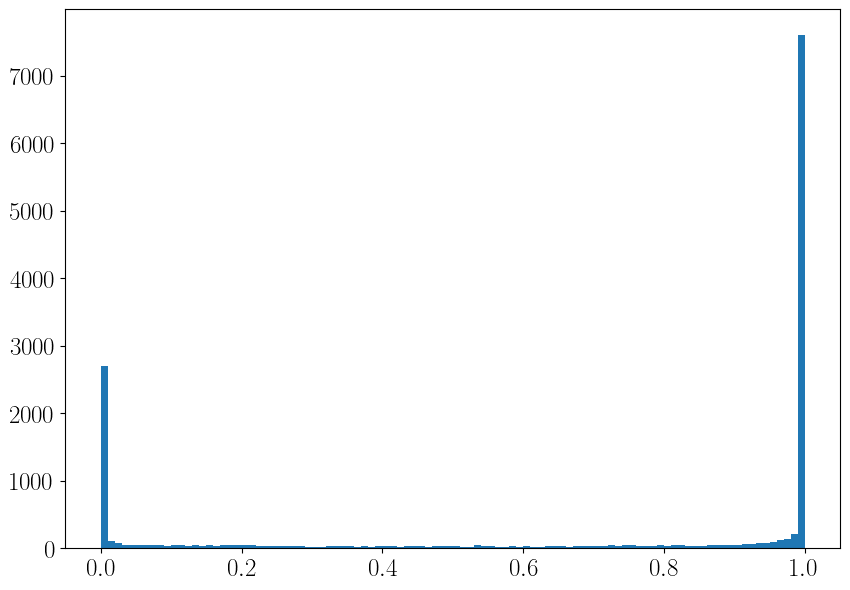

In [29]:
plt.hist(posterior.ravel(), range=(0, 1), bins = 100)
#plt.yscale('log')
#plt.xscale('log')
plt.show()

/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_12892/3348140446.py:2: UserWarning: The following kwargs were not used by contour: 'range'
  plt.contourf(X, Y, posterior, levels=10, cmap='Blues', range= (0, 1))


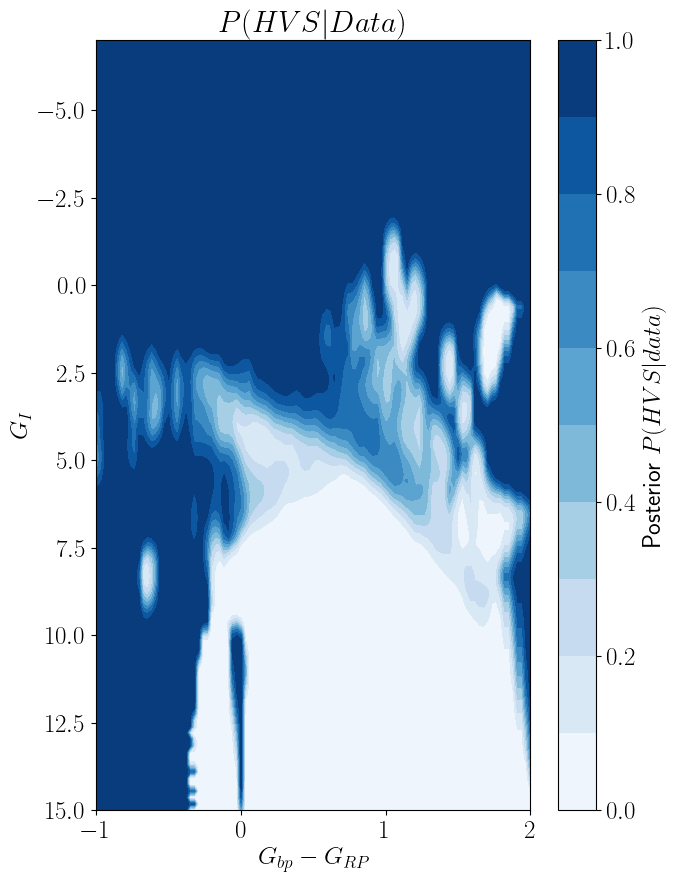

In [32]:
plt.figure(figsize=(7, 10))
plt.contourf(X, Y, posterior, levels=10, cmap='Blues', range= (0, 1))
plt.colorbar(label="Posterior $P(HVS | data)$")
plt.xlabel("$G_{bp} - G_{RP}$")
plt.ylabel("$G_I$")
plt.xlim(-1,2)
plt.ylim(15, -7)
#plt.ylim(y_range[0], y_range[1])
plt.title("$P(HVS|Data)$")

plt.show()